In [10]:
!pip install MissForest
!pip install catboost
!pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=b8f9717fec11ad0431e681f8bf256a2d087896952c922a64ae511732f9172311
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecardpy


# MODELO LGBM

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,roc_curve,auc,classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_recall_curve, average_precision_score,precision_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
import missingno as msno

from sklearn import preprocessing

from missforest import MissForest

import scorecardpy as sc

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Data set
train_df = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/train.csv", sep = ",")
test_df_private = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/test_private.csv", sep = ",")
test_df_public = pd.read_csv("/content/drive/MyDrive/DATATHON - 2/test_public.csv", sep = ",")
print('TRAIN')
print(train_df.shape)
print('TEST_PRIVATE')
print(test_df_private.shape)
print('TEST_PUBLIC')
print(test_df_public.shape)

TRAIN
(347246, 28)
TEST_PRIVATE
(43406, 27)
TEST_PUBLIC
(43406, 28)


# TRAIN

In [ ]:
info_data = {
    'Tipo de Dato': train_df.dtypes,
    'Valores Nulos': train_df.isnull().sum(),
    'Valores unicos': train_df.nunique(),
    '% Valores Nulos': np.round(train_df.isnull().sum()/train_df.shape[0]*100,2),
    'Valores No Nulos': train_df.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,50191,2,14.45,297055
VEGETABLES,float64,47387,2,13.65,299859
HIV,float64,40794,2,11.75,306452
FRUITS,float64,40254,2,11.59,306992
BMI,float64,36960,3702,10.64,310286
FRIED_POTATOES,float64,35302,3,10.17,311944
HEAVY_DRINKERS,float64,27583,2,7.94,319663
SMOKE,float64,19263,2,5.55,327983
E_CIGARETTES,float64,18884,4,5.44,328362
TABACCO_PRODUCTS,float64,18033,3,5.19,329213


In [7]:
categorical_columns = ['SEX', 'HEALTH', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH','PHYSICAL_ACTIVITIES', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL','SKIN_CANCER', 'CANCER', 'BRONCHITIS', 'DEPRESSIVE_DISORDER','KIDNEY_DISEASE', 'DIABETES', 'ARTHRITIS', 'DIFFICULTY_WALKING','SMOKE', 'TABACCO_PRODUCTS', 'E_CIGARETTES', 'HEAVY_DRINKERS', 'HIV','FRUITS', 'VEGETABLES', 'FRIED_POTATOES', 'ETHNICITY']

### Imputación MISS FOREST

In [8]:
df_mixed_imputed_1 = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_1.csv')

In [ ]:
df_mixed_imputed_1

,SEX,ETHNICITY,AGE,DIABETES,PHYSICAL_ACTIVITIES,CANCER,HEALTH,SKIN_CANCER,KIDNEY_DISEASE,BLOOD_PRESSURE,...,SMOKE,HEAVY_DRINKERS,FRIED_POTATOES,BMI,FRUITS,HIV,VEGETABLES,HIGH_CHOLESTEROL,CHD_OR_MI,ID
0,1,1,34,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,3421.000000,2.0,2.0,1.0,2.0,1.0,PID2022_316043
1,1,1,76,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,2870.000000,2.0,2.0,1.0,1.0,0.0,PID2022_024501
2,2,2,69,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,2.0,3293.136572,2.0,2.0,1.0,2.0,1.0,PID2022_393860
3,2,5,36,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2775.555893,1.0,1.0,2.0,2.0,1.0,PID2022_029988
4,2,1,21,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,3328.000000,1.0,2.0,1.0,1.0,1.0,PID2022_308442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347241,1,6,63,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,1.0,1.0,2.0,2414.000000,1.0,2.0,1.0,2.0,1.0,PID2022_422670
347242,2,1,77,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,1980.000000,2.0,2.0,1.0,2.0,1.0,PID2022_085529
347243,1,5,66,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,2568.000000,2.0,2.0,1.0,2.0,1.0,PID2022_231867
347244,2,1,79,3.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2480.000000,1.0,2.0,1.0,1.0,1.0,PID2022_422201


### TRANSFORMACION DE VARIABLES

##### WOE

Usamos WOE porque:
1. Mejora la relación entre las variables y el objetivo: Al aplicar WOE, las variables tienden a mostrar una relación más lineal con el objetivo, lo que facilita la interpretación y mejora el rendimiento del modelo.
2. Manejo de valores extremos: WOE puede ayudar a manejar valores extremos o desequilibrios en los datos, ya que transforma la variable original.
3. Mejora la estabilidad del modelo: WOE también puede ayudar a reducir el sobreajuste (overfitting) en modelos predictivos.

In [12]:
df_mixed_imputed_1 = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_1.csv')

In [13]:
df_mixed_imputed_1.drop(columns=['Unnamed: 0'],inplace=True)

In [14]:
df_mixed_imputed_1

,SEX,ETHNICITY,AGE,DIABETES,PHYSICAL_ACTIVITIES,CANCER,HEALTH,SKIN_CANCER,KIDNEY_DISEASE,BLOOD_PRESSURE,...,SMOKE,HEAVY_DRINKERS,FRIED_POTATOES,BMI,FRUITS,HIV,VEGETABLES,HIGH_CHOLESTEROL,CHD_OR_MI,ID
0,1,1,34,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,3421.000000,2.0,2.0,1.0,2.0,1.0,PID2022_316043
1,1,1,76,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1.0,1.0,3.0,2870.000000,2.0,2.0,1.0,1.0,0.0,PID2022_024501
2,2,2,69,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,2.0,3293.136572,2.0,2.0,1.0,2.0,1.0,PID2022_393860
3,2,5,36,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2775.555893,1.0,1.0,2.0,2.0,1.0,PID2022_029988
4,2,1,21,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,3328.000000,1.0,2.0,1.0,1.0,1.0,PID2022_308442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347241,1,6,63,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,1.0,1.0,2.0,2414.000000,1.0,2.0,1.0,2.0,1.0,PID2022_422670
347242,2,1,77,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,1980.000000,2.0,2.0,1.0,2.0,1.0,PID2022_085529
347243,1,5,66,3.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,2568.000000,2.0,2.0,1.0,2.0,1.0,PID2022_231867
347244,2,1,79,3.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2480.000000,1.0,2.0,1.0,1.0,1.0,PID2022_422201


Con ayuda de woebin se crean los cortes optimos, internamente usa el beginning supervisor para hacer el cortes.

In [15]:
df_mixed_imputed_1['CHD_OR_MI']  = df_mixed_imputed_1['CHD_OR_MI'].astype(int)
data = df_mixed_imputed_1.drop(columns=['ID'])

# Generar bins supervisados
bins = sc.woebin(data, y='CHD_OR_MI', method='tree')  # Método supervisado tipo árbol

[INFO] creating woe binning ...
Binning on 347246 rows and 27 columns in 00:00:53


In [16]:
data_woe_lgbm = sc.woebin_ply(data, bins)
data_woe_lgbm

[INFO] converting into woe values ...
Woe transformating on 347246 rows and 26 columns in 00:00:49


,CHD_OR_MI,MENTAL_HEALTH_woe,PHYSICAL_ACTIVITIES_woe,BMI_woe,HEALTH_woe,FRUITS_woe,SEX_woe,PHYSICAL_HEALTH_woe,SKIN_CANCER_woe,DEPRESSIVE_DISORDER_woe,...,HEAVY_DRINKERS_woe,BLOOD_PRESSURE_woe,HIGH_CHOLESTEROL_woe,DIABETES_woe,FRIED_POTATOES_woe,KIDNEY_DISEASE_woe,CANCER_woe,VEGETABLES_woe,E_CIGARETTES_woe,BRONCHITIS_woe
0,1,0.278566,0.216871,-0.253047,0.424586,-0.028799,-0.251342,0.350133,0.112523,0.073583,...,-0.022144,0.903476,0.680150,0.286264,0.043669,0.0,0.116712,0.025733,-0.002216,0.197662
1,0,-0.031261,-0.500906,0.059375,0.424586,-0.028799,-0.251342,0.350133,-0.761965,0.073583,...,-0.022144,-0.719476,-0.689157,-1.086817,-0.244892,0.0,0.116712,0.025733,0.009401,0.197662
2,1,-0.031261,-0.500906,-0.253047,0.424586,-0.028799,0.271145,0.350133,0.112523,0.073583,...,-0.022144,-0.719476,0.680150,-1.086817,0.038245,0.0,-0.759372,0.025733,-0.002216,0.197662
3,1,-0.031261,0.216871,0.059375,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,-0.022144,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,-0.125462,-0.002216,0.197662
4,1,0.278566,0.216871,-0.253047,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,-0.022144,0.903476,-0.689157,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347241,1,0.278566,0.216871,0.250090,0.424586,0.015474,-0.251342,-1.037902,0.112523,0.073583,...,-0.022144,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662
347242,1,-0.031261,0.216871,0.250090,0.424586,-0.028799,0.271145,0.350133,0.112523,0.073583,...,-0.022144,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662
347243,1,-0.031261,0.216871,0.059375,0.424586,-0.028799,-0.251342,-0.059963,0.112523,0.073583,...,-0.022144,0.903476,0.680150,0.286264,0.043669,0.0,0.116712,0.025733,-0.002216,0.197662
347244,1,-0.031261,0.216871,0.250090,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,-0.022144,-0.719476,-0.689157,0.286264,0.043669,0.0,-0.759372,0.025733,-0.002216,0.197662


In [17]:
df_mixed_imputed_1 = pd.concat([data_woe_lgbm,df_mixed_imputed_1['ID']],axis=1)
df_mixed_imputed_1

,CHD_OR_MI,MENTAL_HEALTH_woe,PHYSICAL_ACTIVITIES_woe,BMI_woe,HEALTH_woe,FRUITS_woe,SEX_woe,PHYSICAL_HEALTH_woe,SKIN_CANCER_woe,DEPRESSIVE_DISORDER_woe,...,BLOOD_PRESSURE_woe,HIGH_CHOLESTEROL_woe,DIABETES_woe,FRIED_POTATOES_woe,KIDNEY_DISEASE_woe,CANCER_woe,VEGETABLES_woe,E_CIGARETTES_woe,BRONCHITIS_woe,ID
0,1,0.278566,0.216871,-0.253047,0.424586,-0.028799,-0.251342,0.350133,0.112523,0.073583,...,0.903476,0.680150,0.286264,0.043669,0.0,0.116712,0.025733,-0.002216,0.197662,PID2022_316043
1,0,-0.031261,-0.500906,0.059375,0.424586,-0.028799,-0.251342,0.350133,-0.761965,0.073583,...,-0.719476,-0.689157,-1.086817,-0.244892,0.0,0.116712,0.025733,0.009401,0.197662,PID2022_024501
2,1,-0.031261,-0.500906,-0.253047,0.424586,-0.028799,0.271145,0.350133,0.112523,0.073583,...,-0.719476,0.680150,-1.086817,0.038245,0.0,-0.759372,0.025733,-0.002216,0.197662,PID2022_393860
3,1,-0.031261,0.216871,0.059375,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,-0.125462,-0.002216,0.197662,PID2022_029988
4,1,0.278566,0.216871,-0.253047,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,0.903476,-0.689157,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662,PID2022_308442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347241,1,0.278566,0.216871,0.250090,0.424586,0.015474,-0.251342,-1.037902,0.112523,0.073583,...,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662,PID2022_422670
347242,1,-0.031261,0.216871,0.250090,0.424586,-0.028799,0.271145,0.350133,0.112523,0.073583,...,0.903476,0.680150,0.286264,0.038245,0.0,0.116712,0.025733,-0.002216,0.197662,PID2022_085529
347243,1,-0.031261,0.216871,0.059375,0.424586,-0.028799,-0.251342,-0.059963,0.112523,0.073583,...,0.903476,0.680150,0.286264,0.043669,0.0,0.116712,0.025733,-0.002216,0.197662,PID2022_231867
347244,1,-0.031261,0.216871,0.250090,0.424586,0.015474,0.271145,0.350133,0.112523,0.073583,...,-0.719476,-0.689157,0.286264,0.043669,0.0,-0.759372,0.025733,-0.002216,0.197662,PID2022_422201


Ahora como se puede observar, hay dos variables que tienen valores 0 de WOE, estas variables no aportan al modelo es por ello que se recomienda retirarlas.

In [18]:
df_mixed_imputed_1.drop(columns=['KIDNEY_DISEASE_woe','TABACCO_PRODUCTS_woe'],inplace=True)

### Modelado

In [19]:
X = df_mixed_imputed_1.drop(columns=['ID', 'CHD_OR_MI'])
y = df_mixed_imputed_1['CHD_OR_MI']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [20]:
y_train.value_counts(normalize=True)

,proportion
CHD_OR_MI,
1,0.918621
0,0.081379


Ya que usaremos LGBM usaré SMOTE para balancear los datos, ya que no es muy robusto cuando se tiene data desvalanceada.
No quiero que target este 50% en cada categoría, ya que la categoría de menor tamaño es muy baja se recomienda que solo tenga a lo mucho un 30% del total.


In [21]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.5,random_state=46)  # La clase minoritaria tendrá el 50% de las muestras de la clase mayoritaria
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [22]:
y_train.value_counts(normalize=True)

,proportion
CHD_OR_MI,
1,0.666668
0,0.333332


En este caso usaré el modelo más simple de lgbm, no haré un barrido de hiperparámetros ya que cuando lo realicé, las métricas no variaban mucho.

In [23]:
from sklearn.metrics import make_scorer, f1_score
best_model = LGBMClassifier(random_state = 4)
best_model.fit(X_train, y_train)


# predecimos el train y test con la probabilidad para validar luego
predict_train_lg = best_model.predict_proba(X_train)[:,1]
predict_test_lg = best_model.predict_proba(X_test)[:,1]

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg)))
print("auc o Roc on testing in LGBMClassifier  data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg)))
print("F1_score:",f1_score(y_train, y_pred_train))
print("F1_score:",f1_score(y_test, y_pred_test))

[LightGBM] [Info] Number of positive: 223291, number of negative: 111645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.505935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4449
[LightGBM] [Info] Number of data points in the train set: 334936, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666668 -> initscore=0.693152
[LightGBM] [Info] Start training from score 0.693152
auc o Roc on training in LGBMClassifier data : 0.970
auc o Roc on testing in LGBMClassifier  data : 0.842
F1_score: 0.9521323374846097
F1_score: 0.9574665003420385


                Feature  Importance
2               BMI_woe         365
13              AGE_woe         337
19   FRIED_POTATOES_woe         254
5               SEX_woe         203
9         ETHNICITY_woe         189
0     MENTAL_HEALTH_woe         183
4            FRUITS_woe         169
11              HIV_woe         143
22     E_CIGARETTES_woe         143
6   PHYSICAL_HEALTH_woe         114


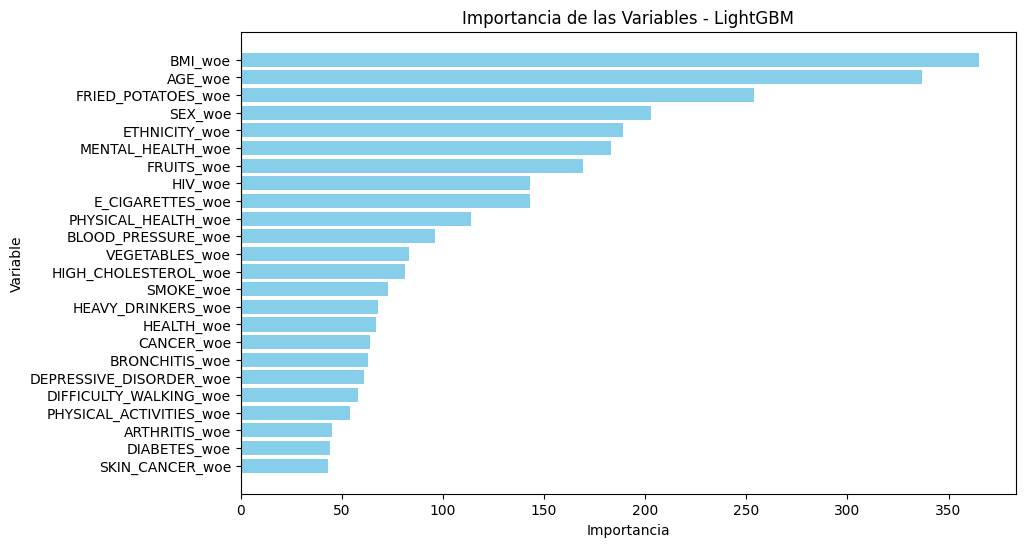

In [24]:
# Obtener la importancia de las variables
feature_importances = best_model.feature_importances_   # Cambié get_feature_importance() por feature_importance()
feature_names = X_train.columns  # Asegúrate de que X_train es un DataFrame con nombres de columnas

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las primeras variables más importantes
print(importance_df.head(10))

# Visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.title('Importancia de las Variables - LightGBM')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

Por este lado, parece que al pasar las variables a numéricas la importancia de algunas variables varia un poco, aunque se siguen conservando las variables que al inicio, en el análisis preliminar, salian como importantes.

**EVIDENCIA DE QUE SI REALICÉ EL GridSearchCV**

In [ ]:
# Numero de arboles
n_estimators = [100, 300, 500]
# porcentaje de variables con la que se contruye un arbol
colsample_bytree = [0.7, 0.8, 0.9]
# profundidad del arbol
max_depth = [-1, 4, 6]
# ratio de aprendizaje por cada arbol
learning_rate = [0.1, 0.15 ,0.2]
# creacion del grip search o grilla generando un diccionario
param_grid = {'n_estimators': n_estimators,
               'colsample_bytree': colsample_bytree,
               'max_depth': max_depth,
               'learning_rate': learning_rate}
print(param_grid)


## Validación Cruzada
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
lgb = LGBMClassifier( random_state = 4)
# Isntacia del grip search ponemos la grilla , la cantidad de kfolds para la validacion cruzada en este caso 5
# n_jobs -1 para la paralelizacion de la ejecucion en la optimizacion del modelo y verbose para mostrar de 2 en 2 los resultados
grid_search = GridSearchCV(estimator = lgb, param_grid = param_grid, cv = 5, verbose = 2,scoring = 'f1')
# FIT para ejecutarlo
grid_search.fit(X_train, y_train)
print(grid_search.best_params_) # mostramos los mejores hiperparametros

predict_train_lg = best_model.predict_proba(X_train)[:,1]
predict_test_lg = best_model.predict_proba(X_test)[:,1]

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

# imprimimos el roc de train y test con la data real y la prediccion de la probabilidad del modelo
print("auc o Roc on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg)))
print("auc o Roc on testing in LGBMClassifier  data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg)))
print("F1_score:",f1_score(y_train, y_pred_train))
print("F1_score:",f1_score(y_test, y_pred_test))

{'n_estimators': [100, 300, 500], 'colsample_bytree': [0.7, 0.8, 0.9], 'max_depth': [-1, 4, 6], 'learning_rate': [0.1, 0.15, 0.2]}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   7.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   6.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   7.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   5.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100; total time=   5.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=300; total time=  15.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=300; total time=  15.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=300; total time=  15.8s

El mismo procedimiento se realizó para la data test public y private.

# TEST PUBLIC

In [ ]:
test_df_public

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,1.0,2,70,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_100531
1,1.0,1,32,1.0,3.0,2.0,1.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1,PID2022_043184
2,1.0,1,69,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,3.0,4.0,1.0,2.0,1.0,2.0,1.0,1,PID2022_071971
3,1.0,1,36,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,2,PID2022_070778
4,1.0,1,63,1.0,2.0,1.0,1.0,2.0,1.0,2.0,...,2.0,3.0,4.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_082363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,0.0,1,69,2.0,1.0,3.0,1.0,2.0,1.0,2.0,...,2.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,6,PID2022_256399
43402,1.0,2,57,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PID2022_326390
43403,0.0,1,75,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,5,PID2022_178405
43404,1.0,2,50,1.0,2.0,1.0,2.0,1.0,2.0,1.0,...,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,1,PID2022_220522


In [ ]:
info_data = {
    'Tipo de Dato': train_df.dtypes,
    'Valores Nulos': train_df.isnull().sum(),
    'Valores unicos': train_df.nunique(),
    '% Valores Nulos': np.round(train_df.isnull().sum()/train_df.shape[0]*100,2),
    'Valores No Nulos': train_df.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,50191,2,14.45,297055
VEGETABLES,float64,47387,2,13.65,299859
HIV,float64,40794,2,11.75,306452
FRUITS,float64,40254,2,11.59,306992
BMI,float64,36960,3702,10.64,310286
FRIED_POTATOES,float64,35302,3,10.17,311944
HEAVY_DRINKERS,float64,27583,2,7.94,319663
SMOKE,float64,19263,2,5.55,327983
E_CIGARETTES,float64,18884,4,5.44,328362
TABACCO_PRODUCTS,float64,18033,3,5.19,329213


In [ ]:
test_df_public_1 = test_df_public.drop(columns = ['CHD_OR_MI','ID'])

In [ ]:
df_mixed_imputed_public = imputer_mixed.fit_transform(test_df_public_1)

 40%|████      | 4/10 [00:03<00:05,  1.18it/s]


In [ ]:
df_mixed_imputed_public_1 = pd.concat([df_mixed_imputed_public,test_df_public[['CHD_OR_MI','ID']]],axis=1)

In [ ]:
df_mixed_imputed_public_1.to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_public.csv')

In [ ]:
df_mixed_imputed_public = pd.read_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_public.csv')

In [ ]:
df_mixed_imputed_public_1.shape

(43406, 28)

In [ ]:
new_data = df_mixed_imputed_public_1.drop(columns=['ID'])

data_woe_new = sc.woebin_ply(new_data, bins)

[INFO] converting into woe values ...


In [ ]:
data_woe_new['TABACCO_PRODUCTS_woe']

,TABACCO_PRODUCTS_woe
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
43401,0.0
43402,0.0
43403,0.0
43404,0.0


In [ ]:
df_mixed_imputed_public_1 = pd.concat([data_woe_new.drop(columns=['TABACCO_PRODUCTS_woe','KIDNEY_DISEASE_woe']),df_mixed_imputed_public_1['ID']],axis=1)
df_mixed_imputed_public_1

,CHD_OR_MI,PHYSICAL_HEALTH_woe,FRIED_POTATOES_woe,ETHNICITY_woe,E_CIGARETTES_woe,BMI_woe,SEX_woe,FRUITS_woe,HIGH_CHOLESTEROL_woe,PHYSICAL_ACTIVITIES_woe,...,MENTAL_HEALTH_woe,DIFFICULTY_WALKING_woe,SKIN_CANCER_woe,ARTHRITIS_woe,AGE_woe,CANCER_woe,DIABETES_woe,HEALTH_woe,HIV_woe,ID
0,1.0,0.350133,0.038245,-0.076764,-0.002216,0.250090,0.271145,0.015474,-0.689157,0.216871,...,-0.031261,0.371524,-0.761965,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_100531
1,1.0,-1.037902,0.043669,-0.076764,-0.002216,0.250090,-0.251342,0.015474,0.680150,0.216871,...,0.278566,0.371524,0.112523,-0.635960,2.200103,0.116712,0.286264,0.424586,0.118536,PID2022_043184
2,1.0,0.350133,0.043669,-0.076764,0.009401,-0.105235,-0.251342,0.015474,0.680150,0.216871,...,-0.031261,0.371524,0.112523,0.488876,-0.853119,0.116712,-1.086817,0.424586,-0.049367,PID2022_071971
3,1.0,0.350133,-0.244892,0.135023,-0.002216,-0.105235,-0.251342,0.015474,0.680150,0.216871,...,-0.031261,0.371524,0.112523,-0.635960,2.200103,0.116712,0.286264,0.424586,0.118536,PID2022_070778
4,1.0,-0.059963,0.043669,-0.076764,0.009401,0.059375,-0.251342,0.015474,-0.689157,0.216871,...,-0.031261,0.371524,0.112523,0.488876,-0.270171,0.116712,0.286264,0.424586,-0.049367,PID2022_082363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,0.0,0.350133,0.043669,0.350891,-0.002216,-0.253047,-0.251342,-0.028799,-0.689157,0.216871,...,-0.276201,0.371524,0.112523,-0.635960,-0.853119,0.116712,-1.086817,-1.138754,0.118536,PID2022_256399
43402,1.0,0.350133,0.043669,-0.076764,-0.002216,0.059375,0.271145,0.015474,0.680150,0.216871,...,-0.031261,0.371524,0.112523,0.488876,0.206011,0.116712,0.286264,0.424586,-0.049367,PID2022_326390
43403,0.0,0.350133,0.043669,0.350891,-0.002216,-0.253047,-0.251342,0.015474,-0.689157,0.216871,...,-0.031261,0.371524,0.112523,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_178405
43404,1.0,-0.059963,0.038245,-0.076764,-0.002216,0.250090,0.271145,-0.028799,0.680150,-0.500906,...,-0.031261,0.371524,-0.761965,0.488876,1.031162,0.116712,0.286264,0.424586,0.118536,PID2022_220522


In [ ]:
X_test = df_mixed_imputed_public_1.drop(columns = ['CHD_OR_MI','ID'])
y_test = df_mixed_imputed_public_1['CHD_OR_MI']

In [ ]:
best_model

LGBMClassifier(random_state=4)

In [ ]:
print("\nResultados del Modelo con Catboost sin smote en la data testing:")
y_pred_test_catboost = best_model.predict(X_test)
y_pred_proba_test_catboost = best_model.predict_proba(X_test)[:, 1]


# Cálculo de métricas
cm_catboost_test = confusion_matrix(y_test, y_pred_test_catboost)
sensitivity_catboost_test = recall_score(y_test, y_pred_test_catboost)
specificity_catboost_test = cm_catboost_test[0, 0] / sum(cm_catboost_test[0, :])
accuracy_catboost_test = accuracy_score(y_test, y_pred_test_catboost)
balanced_accuracy_catboost_test = (sensitivity_catboost_test + specificity_catboost_test) / 2
logloss_catboost_test = log_loss(y_test, y_pred_proba_test_catboost)
f1score_catboost_test = f1_score(y_test, y_pred_test_catboost)  # Cálculo del F1-score
precision_catboost_test = cm_catboost_test[1, 1] / (cm_catboost_test[1, 1] + cm_catboost_test[0, 1])
average_precision_catboost_test = average_precision_score(y_test, y_pred_proba_test_catboost)


# Mostrar métricas
print("\nResultados con catboost:")
print("Matriz de Confusión:\n", cm_catboost_test)
print(f"Sensibilidad: {sensitivity_catboost_test:.4f}")
print(f"Especificidad: {specificity_catboost_test:.4f}")
print(f"Accuracy: {accuracy_catboost_test:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_catboost_test:.4f}")
print(f"Log-Loss (test): {logloss_catboost_test:.4f}")
print(f"f1score (test): {f1score_catboost_test:.4f}")
print(f"Precisión (test): {precision_catboost_test:.4f}")
print(f"Average Precision (AP) (test): {average_precision_catboost_test:.4f}")


Resultados del Modelo con Catboost sin smote en la data testing:

Resultados con catboost:
Matriz de Confusión:
 [[  206  3326]
 [  246 39628]]
Sensibilidad: 0.9938
Especificidad: 0.0583
Accuracy: 0.9177
Balanced Accuracy: 0.5261
Log-Loss (test): 0.2257
f1score (test): 0.9569
Precisión (test): 0.9226
Average Precision (AP) (test): 0.9811


In [ ]:
df_mixed_imputed_public_1['Predicciones'] = y_pred_test_catboost
df_mixed_imputed_public_1['Predicciones_proba'] = y_pred_proba_test_catboost
df_mixed_imputed_public_1

,CHD_OR_MI,PHYSICAL_HEALTH_woe,FRIED_POTATOES_woe,ETHNICITY_woe,E_CIGARETTES_woe,BMI_woe,SEX_woe,FRUITS_woe,HIGH_CHOLESTEROL_woe,PHYSICAL_ACTIVITIES_woe,...,SKIN_CANCER_woe,ARTHRITIS_woe,AGE_woe,CANCER_woe,DIABETES_woe,HEALTH_woe,HIV_woe,ID,Predicciones,Predicciones_proba
0,1.0,0.350133,0.038245,-0.076764,-0.002216,0.250090,0.271145,0.015474,-0.689157,0.216871,...,-0.761965,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_100531,1,0.806681
1,1.0,-1.037902,0.043669,-0.076764,-0.002216,0.250090,-0.251342,0.015474,0.680150,0.216871,...,0.112523,-0.635960,2.200103,0.116712,0.286264,0.424586,0.118536,PID2022_043184,1,0.978648
2,1.0,0.350133,0.043669,-0.076764,0.009401,-0.105235,-0.251342,0.015474,0.680150,0.216871,...,0.112523,0.488876,-0.853119,0.116712,-1.086817,0.424586,-0.049367,PID2022_071971,1,0.862523
3,1.0,0.350133,-0.244892,0.135023,-0.002216,-0.105235,-0.251342,0.015474,0.680150,0.216871,...,0.112523,-0.635960,2.200103,0.116712,0.286264,0.424586,0.118536,PID2022_070778,1,0.984915
4,1.0,-0.059963,0.043669,-0.076764,0.009401,0.059375,-0.251342,0.015474,-0.689157,0.216871,...,0.112523,0.488876,-0.270171,0.116712,0.286264,0.424586,-0.049367,PID2022_082363,1,0.843071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,0.0,0.350133,0.043669,0.350891,-0.002216,-0.253047,-0.251342,-0.028799,-0.689157,0.216871,...,0.112523,-0.635960,-0.853119,0.116712,-1.086817,-1.138754,0.118536,PID2022_256399,1,0.657047
43402,1.0,0.350133,0.043669,-0.076764,-0.002216,0.059375,0.271145,0.015474,0.680150,0.216871,...,0.112523,0.488876,0.206011,0.116712,0.286264,0.424586,-0.049367,PID2022_326390,1,0.986876
43403,0.0,0.350133,0.043669,0.350891,-0.002216,-0.253047,-0.251342,0.015474,-0.689157,0.216871,...,0.112523,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_178405,1,0.796577
43404,1.0,-0.059963,0.038245,-0.076764,-0.002216,0.250090,0.271145,-0.028799,0.680150,-0.500906,...,-0.761965,0.488876,1.031162,0.116712,0.286264,0.424586,0.118536,PID2022_220522,1,0.985622


In [ ]:
df_mixed_imputed_public_1[['CHD_OR_MI','ID','Predicciones','Predicciones_proba']].to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_public_probas.csv')

# TEST PRIVATE

In [ ]:
test_df_private

,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,2,56,2.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,2.0,2.0,2.0,1,PID2022_152435
1,2,59,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,3.0,4.0,1.0,2.0,2.0,2.0,1.0,1,PID2022_299594
2,2,30,1.0,1.0,2.0,2.0,1.0,NaN,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_065147
3,2,29,2.0,2.0,1.0,1.0,1.0,NaN,2.0,1.0,...,2.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,2,PID2022_333651
4,2,43,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1,PID2022_317306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,2,63,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,...,1.0,3.0,3.0,2.0,2.0,1.0,1.0,3.0,1,PID2022_405631
43402,1,69,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_264185
43403,1,40,2.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,3.0,1.0,2.0,2.0,2.0,3.0,1,PID2022_019640
43404,2,64,2.0,3.0,3.0,2.0,1.0,1.0,2.0,1.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,PID2022_073050


In [ ]:
info_data = {
    'Tipo de Dato': test_df_private.dtypes,
    'Valores Nulos': test_df_private.isnull().sum(),
    'Valores unicos': test_df_private.nunique(),
    '% Valores Nulos': np.round(test_df_private.isnull().sum()/test_df_private.shape[0]*100,2),
    'Valores No Nulos': test_df_private.notnull().sum()
}

# Creando el DataFrame
estructura_datos = pd.DataFrame(info_data)
estructura_datos.sort_values('% Valores Nulos', ascending=False)

,Tipo de Dato,Valores Nulos,Valores unicos,% Valores Nulos,Valores No Nulos
HIGH_CHOLESTEROL,float64,6410,2,14.77,36996
VEGETABLES,float64,5898,2,13.59,37508
HIV,float64,5086,2,11.72,38320
FRUITS,float64,5028,2,11.58,38378
BMI,float64,4488,2309,10.34,38918
FRIED_POTATOES,float64,4414,3,10.17,38992
HEAVY_DRINKERS,float64,3400,2,7.83,40006
SMOKE,float64,2369,2,5.46,41037
E_CIGARETTES,float64,2327,4,5.36,41079
TABACCO_PRODUCTS,float64,2231,3,5.14,41175


In [ ]:
test_df_private_1 = test_df_private.drop(columns = ['ID'])

In [ ]:
df_mixed_imputed_private = imputer_mixed.fit_transform(test_df_private_1)

 33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]


In [ ]:
df_mixed_imputed_private_1 = pd.concat([df_mixed_imputed_private,test_df_private[['ID']]],axis=1)

In [ ]:
df_mixed_imputed_private_1.to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_private_1.csv')

In [ ]:
new_data_private = df_mixed_imputed_private_1.drop(columns=['ID'])

data_woe_new_private = sc.woebin_ply(new_data_private, bins)

[INFO] converting into woe values ...
Woe transformating on 43406 rows and 26 columns in 00:00:10


In [ ]:
df_mixed_imputed_private_1 = pd.concat([data_woe_new_private.drop(columns=['TABACCO_PRODUCTS_woe','KIDNEY_DISEASE_woe']),df_mixed_imputed_private_1['ID']],axis=1)
df_mixed_imputed_private_1

,PHYSICAL_HEALTH_woe,FRIED_POTATOES_woe,ETHNICITY_woe,E_CIGARETTES_woe,BMI_woe,SEX_woe,FRUITS_woe,HIGH_CHOLESTEROL_woe,PHYSICAL_ACTIVITIES_woe,VEGETABLES_woe,...,MENTAL_HEALTH_woe,DIFFICULTY_WALKING_woe,SKIN_CANCER_woe,ARTHRITIS_woe,AGE_woe,CANCER_woe,DIABETES_woe,HEALTH_woe,HIV_woe,ID
0,-1.037902,0.038245,-0.076764,-0.002216,-0.105235,0.271145,-0.028799,-0.689157,-0.500906,-0.125462,...,-0.276201,-1.102648,0.112523,-0.635960,0.206011,0.116712,0.286264,-1.138754,0.118536,PID2022_152435
1,-1.037902,0.043669,-0.076764,0.009401,0.250090,0.271145,-0.028799,0.680150,0.216871,-0.125462,...,-0.031261,0.371524,0.112523,0.488876,0.206011,0.116712,0.286264,0.424586,-0.049367,PID2022_299594
2,0.350133,0.038245,-0.076764,-0.002216,-0.253047,0.271145,0.015474,0.680150,-0.500906,0.025733,...,0.278566,0.371524,0.112523,0.488876,2.200103,0.116712,0.286264,0.424586,-0.049367,PID2022_065147
3,-0.059963,0.043669,0.135023,-0.002216,-0.253047,0.271145,0.015474,0.680150,0.216871,0.025733,...,-0.031261,0.371524,0.112523,0.488876,2.200103,-0.759372,0.286264,-1.138754,0.118536,PID2022_333651
4,0.350133,0.043669,-0.076764,-0.002216,-0.253047,0.271145,-0.028799,0.680150,0.216871,0.025733,...,0.278566,0.371524,0.112523,0.488876,1.031162,0.116712,0.286264,0.424586,0.118536,PID2022_317306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,-0.059963,-0.244892,-0.076764,-0.002216,0.250090,0.271145,0.015474,0.680150,0.216871,0.025733,...,0.278566,0.371524,-0.761965,-0.635960,-0.270171,0.116712,0.286264,0.424586,-0.049367,PID2022_405631
43402,0.350133,0.043669,-0.076764,-0.002216,-0.105235,-0.251342,0.015474,-0.689157,0.216871,0.025733,...,-0.031261,0.371524,0.112523,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_264185
43403,-1.037902,-0.244892,-0.076764,-0.002216,-0.253047,-0.251342,-0.028799,0.680150,0.216871,-0.125462,...,-0.031261,-1.102648,-0.761965,-0.635960,1.031162,0.116712,0.286264,-1.138754,-0.049367,PID2022_019640
43404,-1.037902,0.043669,0.350891,-0.002216,0.250090,0.271145,0.015474,-0.689157,-0.500906,0.025733,...,-0.276201,0.371524,0.112523,0.488876,-0.270171,-0.759372,0.286264,-1.138754,-0.049367,PID2022_073050


In [ ]:
df_mixed_imputed_private_1.columns

Index(['PHYSICAL_HEALTH_woe', 'FRIED_POTATOES_woe', 'ETHNICITY_woe',
       'E_CIGARETTES_woe', 'BMI_woe', 'SEX_woe', 'FRUITS_woe',
       'HIGH_CHOLESTEROL_woe', 'PHYSICAL_ACTIVITIES_woe', 'VEGETABLES_woe',
       'SMOKE_woe', 'BRONCHITIS_woe', 'HEAVY_DRINKERS_woe',
       'DEPRESSIVE_DISORDER_woe', 'BLOOD_PRESSURE_woe', 'MENTAL_HEALTH_woe',
       'DIFFICULTY_WALKING_woe', 'SKIN_CANCER_woe', 'ARTHRITIS_woe', 'AGE_woe',
       'CANCER_woe', 'DIABETES_woe', 'HEALTH_woe', 'HIV_woe', 'ID'],
      dtype='object')

In [ ]:
X_test = df_mixed_imputed_private_1.drop(columns = ['ID'])

In [ ]:
print("\nResultados del Modelo con Catboost sin smote en la data testing:")
y_pred_test_catboost = best_model.predict(X_test)
y_pred_proba_test_catboost = best_model.predict_proba(X_test)[:, 1]


Resultados del Modelo con Catboost sin smote en la data testing:


In [ ]:
df_mixed_imputed_private_1['Predicciones_private'] = y_pred_test_catboost
df_mixed_imputed_private_1['Predicciones_proba_private'] = y_pred_proba_test_catboost
df_mixed_imputed_private_1

,PHYSICAL_HEALTH_woe,FRIED_POTATOES_woe,ETHNICITY_woe,E_CIGARETTES_woe,BMI_woe,SEX_woe,FRUITS_woe,HIGH_CHOLESTEROL_woe,PHYSICAL_ACTIVITIES_woe,VEGETABLES_woe,...,SKIN_CANCER_woe,ARTHRITIS_woe,AGE_woe,CANCER_woe,DIABETES_woe,HEALTH_woe,HIV_woe,ID,Predicciones_private,Predicciones_proba_private
0,-1.037902,0.038245,-0.076764,-0.002216,-0.105235,0.271145,-0.028799,-0.689157,-0.500906,-0.125462,...,0.112523,-0.635960,0.206011,0.116712,0.286264,-1.138754,0.118536,PID2022_152435,1,0.711385
1,-1.037902,0.043669,-0.076764,0.009401,0.250090,0.271145,-0.028799,0.680150,0.216871,-0.125462,...,0.112523,0.488876,0.206011,0.116712,0.286264,0.424586,-0.049367,PID2022_299594,1,0.978955
2,0.350133,0.038245,-0.076764,-0.002216,-0.253047,0.271145,0.015474,0.680150,-0.500906,0.025733,...,0.112523,0.488876,2.200103,0.116712,0.286264,0.424586,-0.049367,PID2022_065147,1,0.994449
3,-0.059963,0.043669,0.135023,-0.002216,-0.253047,0.271145,0.015474,0.680150,0.216871,0.025733,...,0.112523,0.488876,2.200103,-0.759372,0.286264,-1.138754,0.118536,PID2022_333651,1,0.979612
4,0.350133,0.043669,-0.076764,-0.002216,-0.253047,0.271145,-0.028799,0.680150,0.216871,0.025733,...,0.112523,0.488876,1.031162,0.116712,0.286264,0.424586,0.118536,PID2022_317306,1,0.989775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,-0.059963,-0.244892,-0.076764,-0.002216,0.250090,0.271145,0.015474,0.680150,0.216871,0.025733,...,-0.761965,-0.635960,-0.270171,0.116712,0.286264,0.424586,-0.049367,PID2022_405631,1,0.978743
43402,0.350133,0.043669,-0.076764,-0.002216,-0.105235,-0.251342,0.015474,-0.689157,0.216871,0.025733,...,0.112523,0.488876,-0.853119,0.116712,0.286264,0.424586,-0.049367,PID2022_264185,1,0.575913
43403,-1.037902,-0.244892,-0.076764,-0.002216,-0.253047,-0.251342,-0.028799,0.680150,0.216871,-0.125462,...,-0.761965,-0.635960,1.031162,0.116712,0.286264,-1.138754,-0.049367,PID2022_019640,1,0.786368
43404,-1.037902,0.043669,0.350891,-0.002216,0.250090,0.271145,0.015474,-0.689157,-0.500906,0.025733,...,0.112523,0.488876,-0.270171,-0.759372,0.286264,-1.138754,-0.049367,PID2022_073050,1,0.853941


In [ ]:
df_mixed_imputed_private_1[['ID','Predicciones_private','Predicciones_proba_private']].to_csv('/content/drive/MyDrive/DATATHON - 2/df_mixed_imputed_private_probas.csv')